In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
df_fraud = pd.read_csv("Fraud_Data.csv")
df_ip = pd.read_table("IpAddress_to_Country.txt", delimiter=",")

df_fraud.head()

## show column types
# df_fraud.describe()

## show stat distribution
# df_fraud.info()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
df_ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
def ip_to_country(x):
    ip =  x["ip_address"]
    matched = df_ip[(df_ip['lower_bound_ip_address'] <= ip) & (ip <= df_ip["upper_bound_ip_address"])]
    if len(matched) == 1:
        return matched["country"].values[0]
    else:
        return "NA"

df_fraud["country"] = df_fraud.apply(lambda x: ip_to_country(x), axis=1)

In [5]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [6]:
df_fraud["purchase_time"] = pd.to_datetime(df_fraud["purchase_time"])
df_fraud["signup_time"] = pd.to_datetime(df_fraud["signup_time"])

In [7]:
df_fraud["time_diff"] = df_fraud.apply(lambda x: (x["purchase_time"] - x["signup_time"]).seconds, axis=1)

# Signup day and week
df_fraud['signup_day'] = df_fraud['signup_time'].apply(lambda x: x.dayofweek)
df_fraud['purchase_day'] = df_fraud['purchase_time'].apply(lambda x: x.dayofweek)


In [8]:
# Check user number for unique devices
device_num = df_fraud[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
df_fraud = df_fraud.merge(device_num, how='left', on='device_id')

# Check user number for unique ip_address
ip_num = df_fraud[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
df_fraud = df_fraud.merge(ip_num, how='left', on='ip_address')

In [9]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,signup_day,purchase_day,device_num,ip_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,5,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,6,0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,3,3,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,2,1,1


In [10]:
numeric_cols = ['purchase_value','age','time_diff','signup_day','purchase_day','ip_num','device_num']
category_cols = ['source', 'browser','sex', 'country']
label_cols = ['class']
df_one_hot = pd.get_dummies(df_fraud[category_cols],drop_first=True)
df_numeric = df_fraud[numeric_cols]
X = df_numeric.join(df_one_hot)
y = df_fraud[label_cols]

In [53]:
# split train, validation, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2022)

In [54]:
for data,label in zip((X_train, X_val, X_test), (y_train, y_val, y_test)):
    print(data.shape, label.shape)

(74044, 195) (74044, 1)
(31734, 195) (31734, 1)
(45334, 195) (45334, 1)


In [55]:
# training
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)


/var/folders/qx/3n7wvs8n4vqggtx2lm8c7zrr0000gn/T/ipykernel_96699/435869628.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

In [56]:
# prediction
y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)


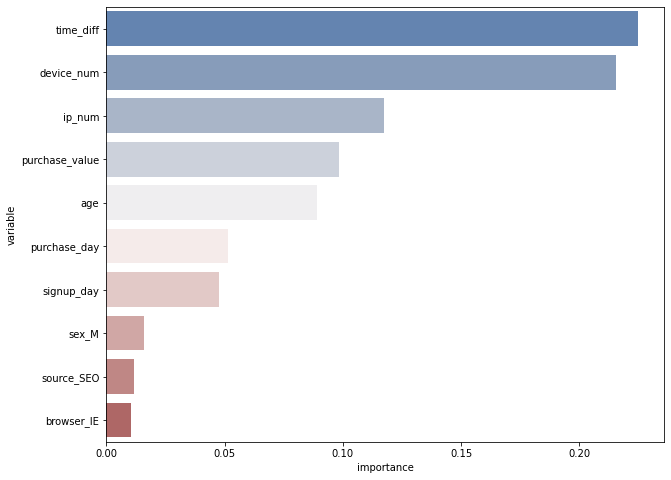

In [85]:
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)
num_features = 10
imp = pd.DataFrame({'importance':importances[indices[-num_features:]], 'variable':[features[i] for i in indices[-num_features:]]})
imp.sort_values('importance',ascending = False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='importance', y='variable', data=imp, palette="vlag")
plt.show()

In [58]:
# performance, no class weight
train_true = np.array(y_train['class'])
test_true = np.array(y_test['class'])
train_pred = np.array(y_pred_train[:,1]) #[class_0, class_1]
test_pred =np.array(y_pred_test[:,1])

print(clf, ", no resampling")
print("------------------")
print(classification_report(y_true=test_true, y_pred=(test_pred>0.5)))

RandomForestClassifier(random_state=0) , no resampling
------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41086
           1       1.00      0.54      0.70      4248

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



**with class weight**

In [59]:
# train
clf = RandomForestClassifier(random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)
# prediction
y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)

# performance, no resampling
train_true = np.array(y_train['class'])
test_true = np.array(y_test['class'])
train_pred = np.array(y_pred_train[:,1]) #[class_0, class_1]
test_pred =np.array(y_pred_test[:,1])

print(clf, ", no resampling")
print("------------------")
print(classification_report(y_true=test_true, y_pred=(test_pred>0.5)))

/var/folders/qx/3n7wvs8n4vqggtx2lm8c7zrr0000gn/T/ipykernel_96699/1891862025.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=0) , no resampling
------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41086
           1       0.99      0.54      0.70      4248

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



In [75]:
# train
clf = RandomForestClassifier(random_state=0, class_weight='balanced_subsample')
clf.fit(X_train, y_train)
# prediction
y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)

# performance, no resampling
train_true = np.array(y_train['class'])
test_true = np.array(y_test['class'])
train_pred = np.array(y_pred_train[:,1]) #[class_0, class_1]
test_pred =np.array(y_pred_test[:,1])

print(clf, ", no resampling")
print("------------------")
print(classification_report(y_true=test_true, y_pred=(test_pred>0.5)))

RandomForestClassifier(class_weight='balanced_subsample', random_state=0) , no resampling
------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     41086
           1       0.99      0.55      0.71      4248

    accuracy                           0.96     45334
   macro avg       0.97      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334



**with resampling**

In [51]:
# handle class imbalance
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
y_train.value_counts(), y_resampled.value_counts()

# train
clf = RandomForestClassifier(random_state=0)
clf.fit(X_resampled, y_resampled)
# prediction
y_pred_train_resample = clf.predict_proba(X_resampled)
y_pred_test = clf.predict_proba(X_test)

# performance, SMOTE resampling
train_true = np.array(y_resampled['class'])
test_true = np.array(y_test['class'])
train_pred = np.array(y_pred_train_resample[:,1]) #[class_0, class_1]
test_pred =np.array(y_pred_test[:,1])

print(clf, ", SMOTE resampling")
print("------------------")
print(classification_report(y_true=test_true, y_pred=(test_pred>0.5)))

/var/folders/qx/3n7wvs8n4vqggtx2lm8c7zrr0000gn/T/ipykernel_96699/2317276764.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=0) , SMOTE resampling
------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     41086
           1       0.70      0.56      0.63      4248

    accuracy                           0.94     45334
   macro avg       0.83      0.77      0.80     45334
weighted avg       0.93      0.94      0.93     45334



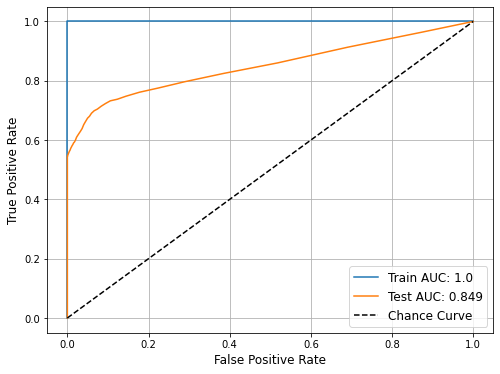

In [76]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)


train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()